<a href="https://colab.research.google.com/github/AliciaFalconCaro/PythonColabExamples/blob/main/DataAnalysisExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from statsmodels.multivariate.manova import MANOVA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('data.csv')
print(df.head())

   timestamp label  raw hr  HR (BPM)  HRV  EDA
0      10645  rest      76       724  400  380
1      11664  rest      76       724  456  365
2      11684  rest      76       724  418  365
3      11704  rest      76       724  401  365
4      11724  rest      76       724  404  365


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892676 entries, 0 to 892675
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  892676 non-null  int64 
 1   label      892483 non-null  object
 2   raw hr     892676 non-null  int64 
 3   HR (BPM)   892676 non-null  int64 
 4   HRV        892676 non-null  int64 
 5   EDA        892676 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.9+ MB


In [ ]:
df.describe()

,timestamp,raw hr,HR (BPM),HRV,EDA
count,8.926760e+05,892676.000000,892676.000000,892676.000000,892676.000000
mean,1.105232e+06,79.398165,773.824086,512.331075,320.403818
std,1.011238e+06,11.648083,152.290389,153.808796,158.003682
min,2.139000e+03,0.000000,252.000000,0.000000,2.000000
25%,5.415162e+05,72.000000,692.000000,426.000000,200.000000
50%,9.059240e+05,78.000000,770.000000,482.000000,337.000000
75%,1.295936e+06,85.000000,842.000000,541.000000,437.000000
max,5.076562e+06,161.000000,2470.000000,971.000000,687.000000


In [ ]:
# Check for missing values
df.isnull().sum()

,0
timestamp,0
label,193
raw hr,0
HR (BPM),0
HRV,0
EDA,0


In [ ]:
# Remove rows with null values
df = df.dropna()

In [ ]:
# Display unique values in the 'label' column
print(df['label'].unique())

['rest' 'experiment']


In [ ]:
# Calculate the proportion of each label
print(df['label'].value_counts(normalize=True))

label
experiment    0.532483
rest          0.467517
Name: proportion, dtype: float64


In [ ]:
# Calculate mean values for each label
print(df.groupby('label').mean())

               timestamp     raw hr   HR (BPM)         HRV         EDA
label                                                                 
experiment  1.317995e+06  81.594221  754.94630  512.596698  298.506616
rest        8.634132e+05  76.901781  795.38844  512.040436  345.349082


# Visualisations

In [ ]:
# Set up the plotting style
plt.style.use('seaborn')

<ipython-input-81-0c730c25fe01>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


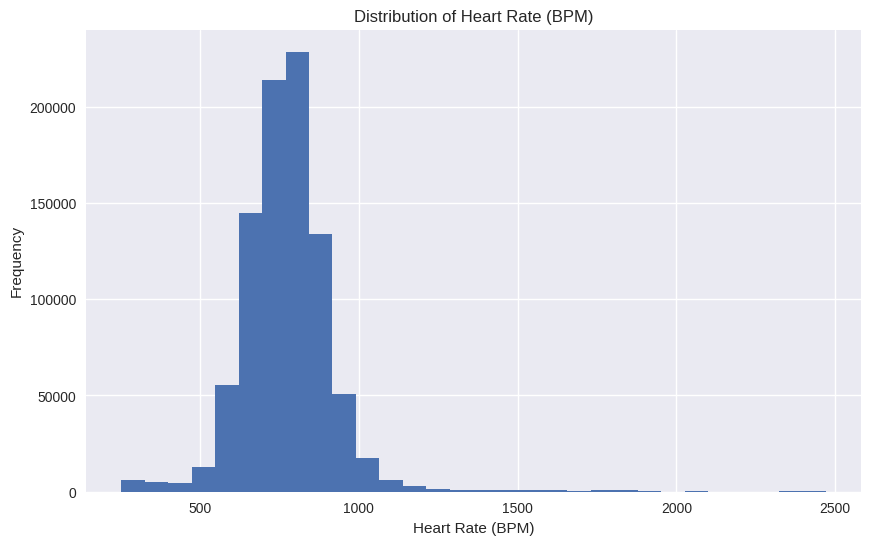

In [ ]:
# Create a histogram of HR (BPM)
plt.figure(figsize=(10, 6))
plt.hist(df['HR (BPM)'], bins=30)
plt.title('Distribution of Heart Rate (BPM)')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Frequency')
plt.show()

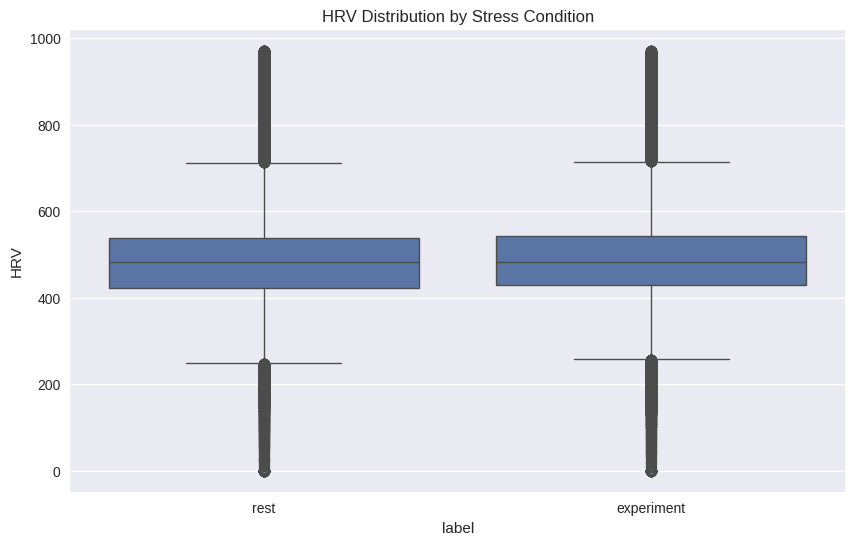

In [ ]:
# Create a box plot of HRV for each label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='HRV', data=df)
plt.title('HRV Distribution by Stress Condition')
plt.show()

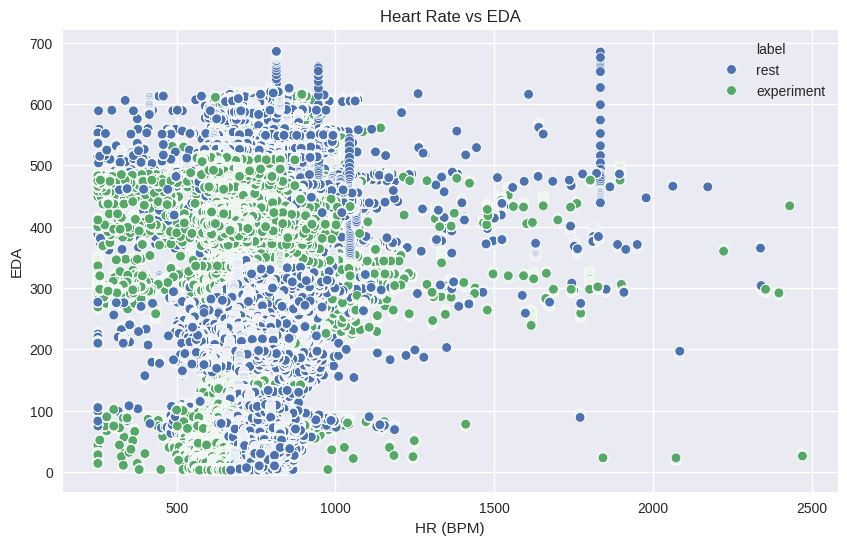

In [ ]:
# Create a scatter plot of HR (BPM) vs EDA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HR (BPM)', y='EDA', hue='label', data=df)
plt.title('Heart Rate vs EDA')
plt.show()

In [ ]:
# Perform a t-test to compare HRV between rest and experiment conditions

rest_hrv = df[df['label'] == 'rest']['HRV']
experiment_hrv = df[df['label'] == 'experiment']['HRV']

t_statistic, p_value = stats.ttest_ind(rest_hrv, experiment_hrv)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -1.7045731931415067
P-value: 0.08827440252799545


In [ ]:
X = df[['HR (BPM)', 'HRV', 'EDA', 'raw hr']]
y = df['label']

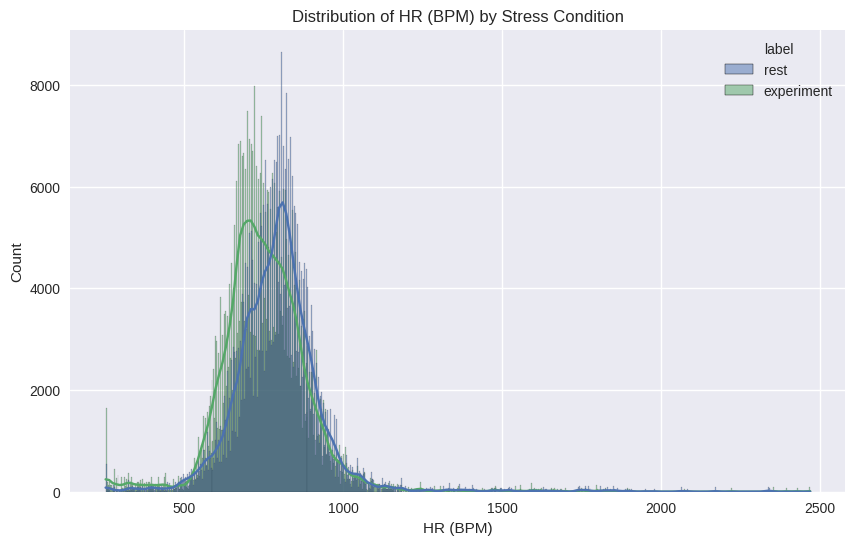

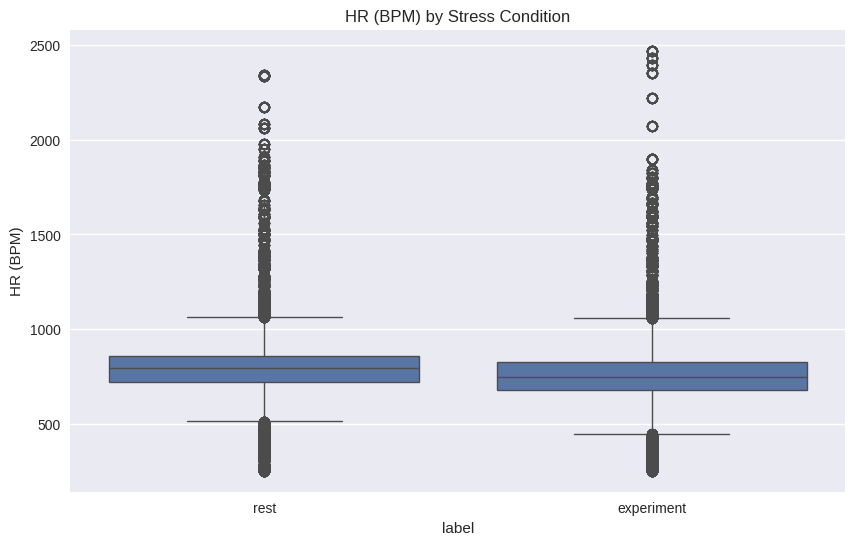

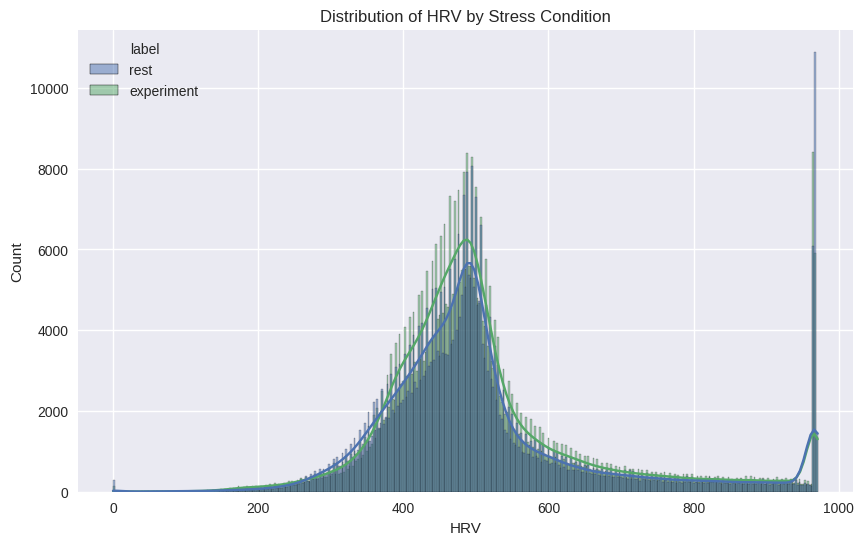

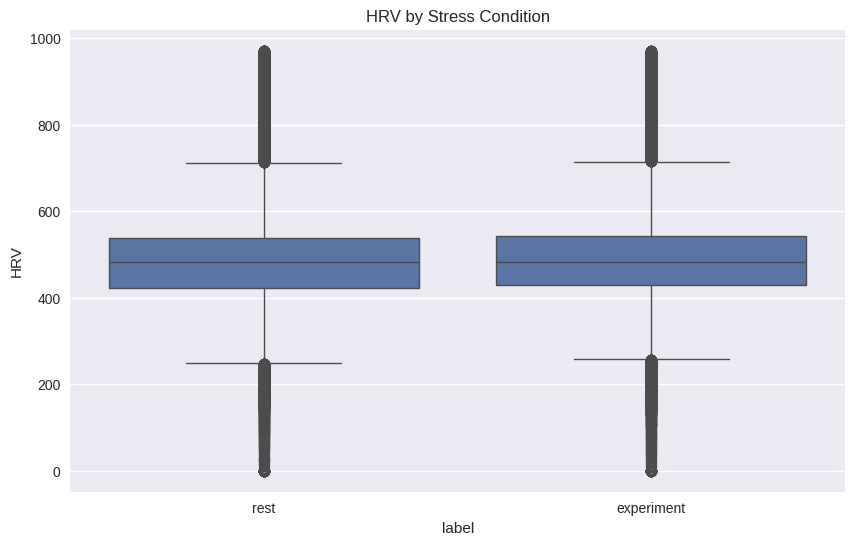

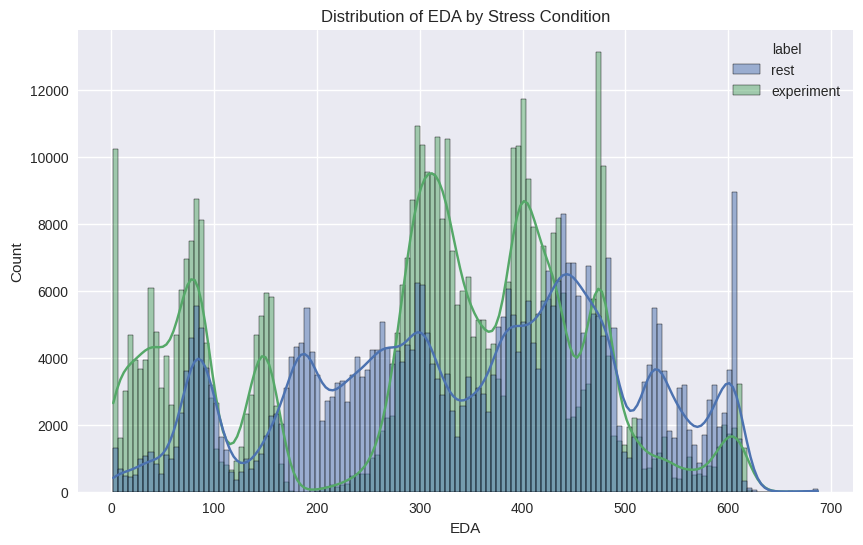

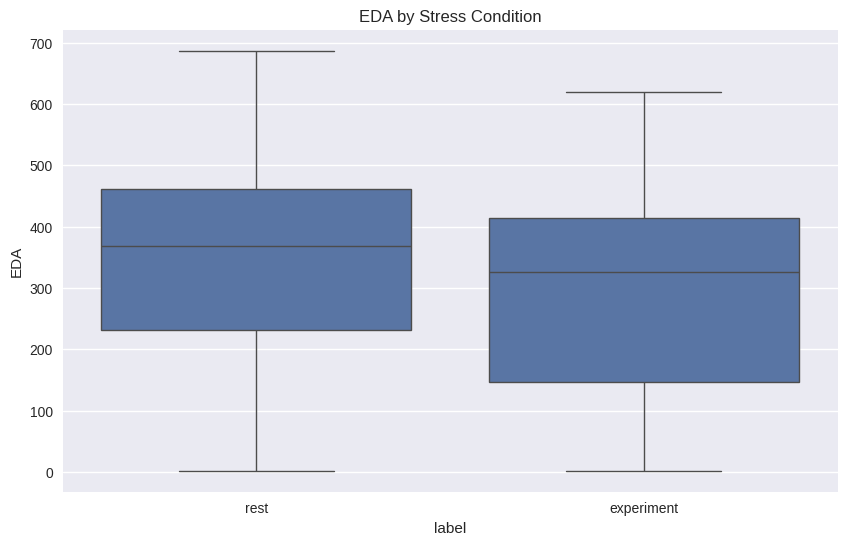

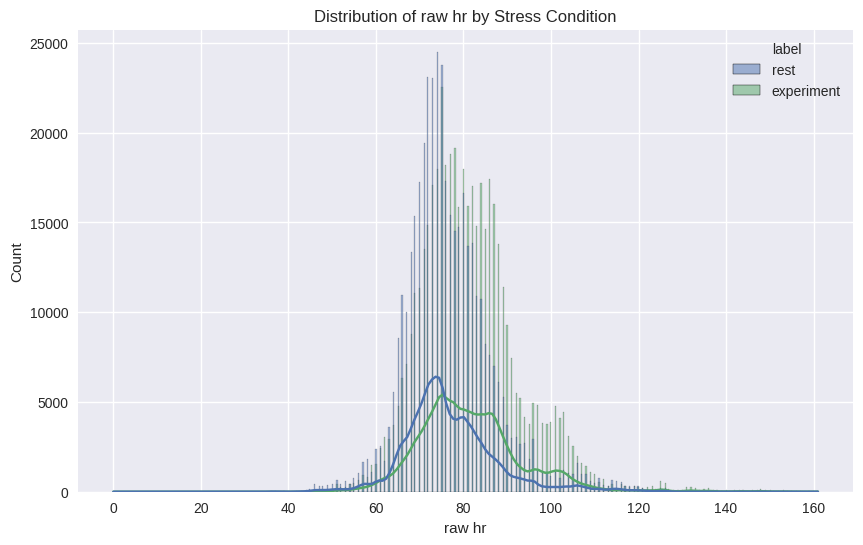

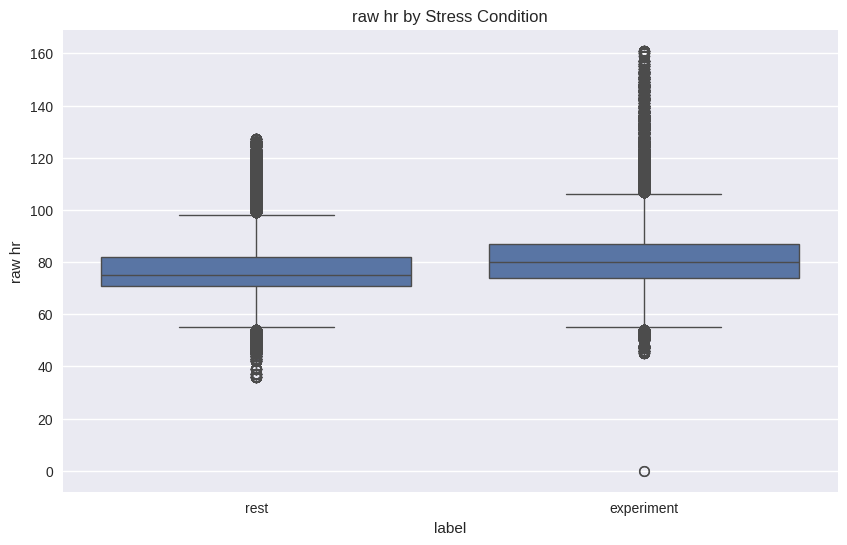

In [ ]:
def plot_feature_distributions(X, y):
    for column in X.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=column, hue='label', kde=True)
        plt.title(f'Distribution of {column} by Stress Condition')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y=column, data=df)
        plt.title(f'{column} by Stress Condition')
        plt.show()

plot_feature_distributions(X, y)

In [ ]:
# ANOVA for each feature
def anova_test(X, y):
    anova_results = {}
    for column in X.columns:
        f_statistic, p_value = f_classif(X[[column]], y)
        anova_results[column] = {'F-statistic': f_statistic[0], 'p-value': p_value[0]}
    return pd.DataFrame(anova_results).T.sort_values('F-statistic', ascending=False)

print("ANOVA results:")
print(anova_test(X, y))

ANOVA results:
           F-statistic   p-value
raw hr    37573.700613  0.000000
EDA       19960.010363  0.000000
HR (BPM)  15952.411597  0.000000
HRV           2.905570  0.088274


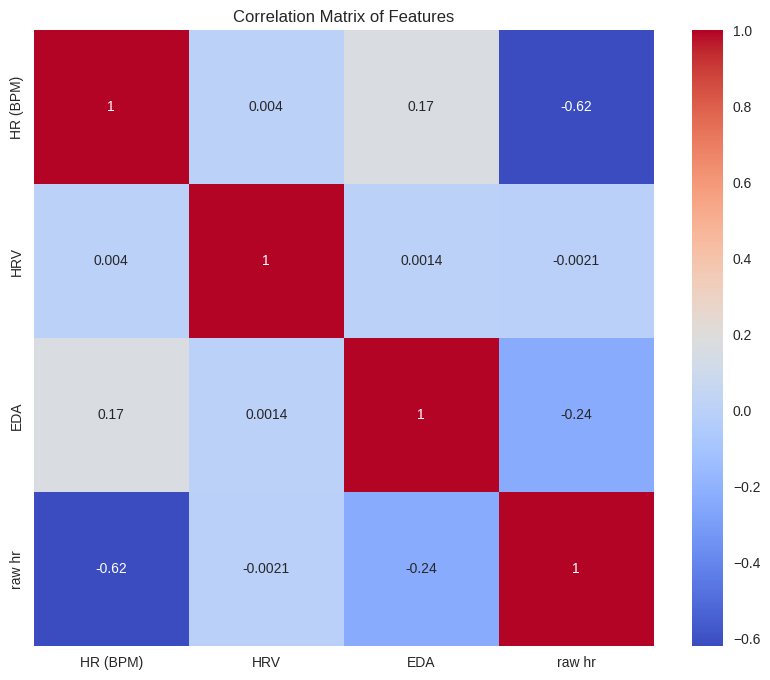

In [ ]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

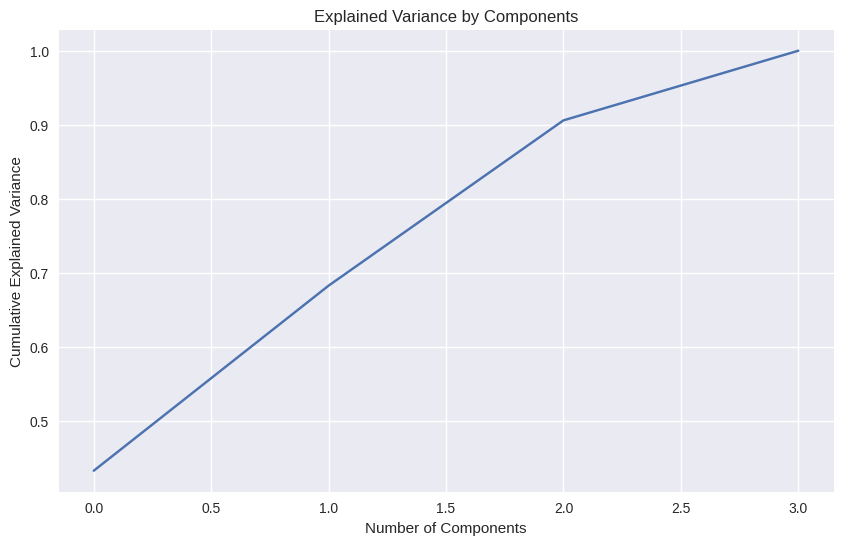

Explained variance ratio:
[0.4326552  0.24999424 0.22327843 0.09407213]


In [ ]:
# PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

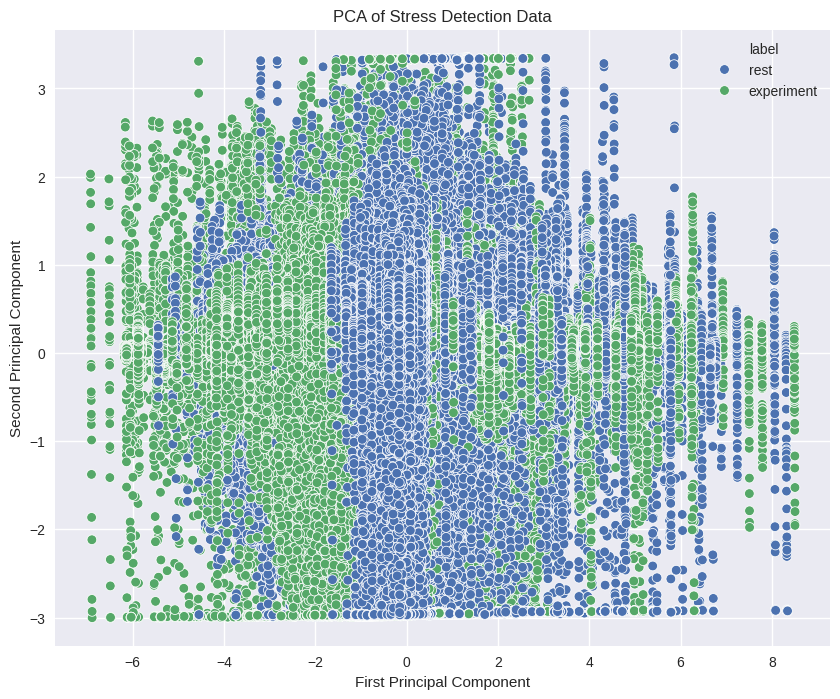

In [ ]:
# Visualize first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Stress Detection Data')
plt.show()

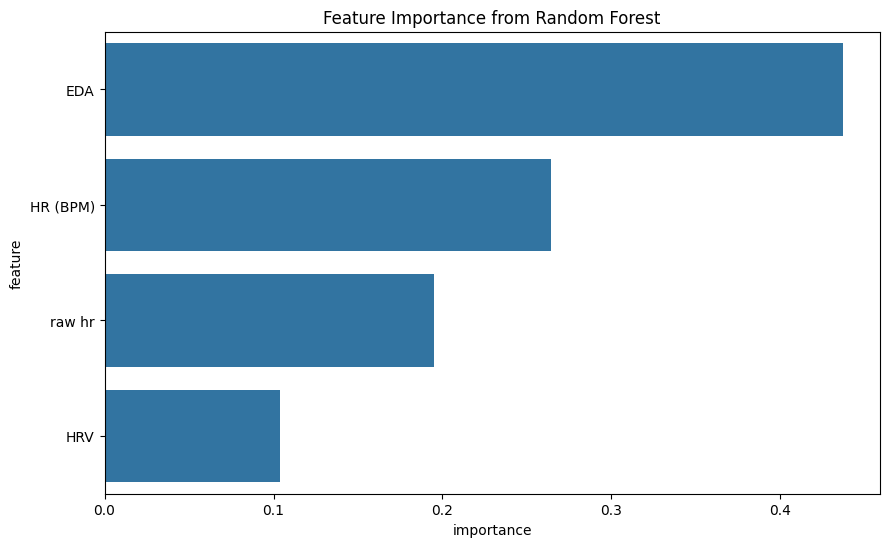

In [ ]:
# Feature Importance based on Random Forest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.show()

# Machine Learning

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "Random Forest": RandomForestClassifier(random_state=42),
    # "SVM": SVC(random_state=42),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Naive Bayes": GaussianNB()
}

In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")


Logistic Regression Results:
Accuracy: 0.5626

Classification Report:
              precision    recall  f1-score   support

  experiment       0.58      0.63      0.61    142723
        rest       0.53      0.48      0.51    125022

    accuracy                           0.56    267745
   macro avg       0.56      0.56      0.56    267745
weighted avg       0.56      0.56      0.56    267745


Confusion Matrix:
[[90116 52607]
 [64512 60510]]

Cross-validation scores: [0.56198579 0.5610494  0.56004098 0.56331084 0.56358296]
Mean CV score: 0.5620

Decision Tree Results:
Accuracy: 0.9788

Classification Report:
              precision    recall  f1-score   support

  experiment       0.98      0.98      0.98    142723
        rest       0.98      0.98      0.98    125022

    accuracy                           0.98    267745
   macro avg       0.98      0.98      0.98    267745
weighted avg       0.98      0.98      0.98    267745


Confusion Matrix:
[[139928   2795]
 [  2874 122148]]



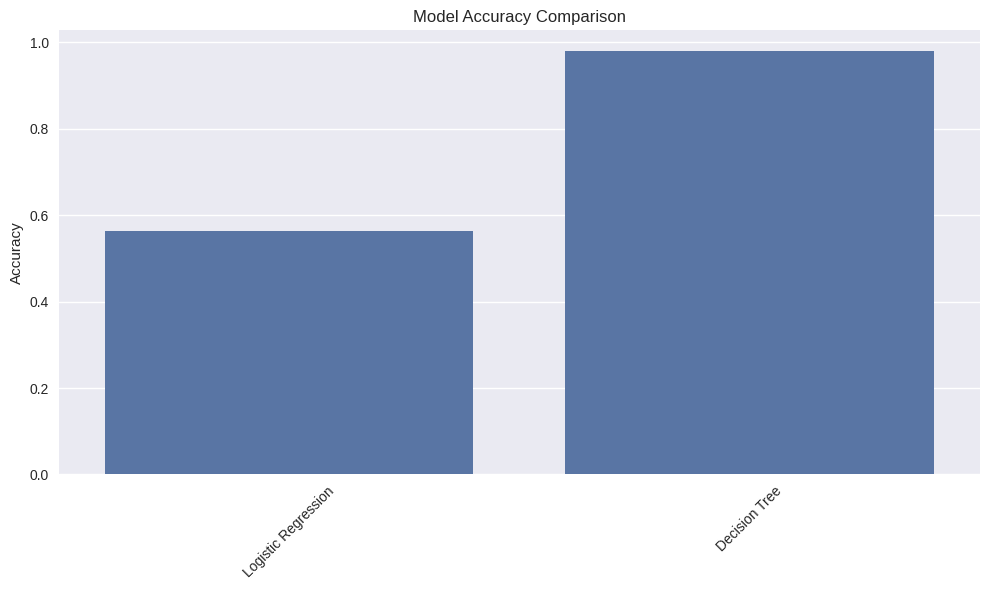

In [ ]:
# Visualize model performance
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter tuning for the best performing model
best_model_name = max(results, key=results.get)
print(f"\nPerforming hyperparameter tuning for {best_model_name}")

if best_model_name == "Logistic Regression":
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2']}
    model = LogisticRegression(random_state=42, solver='liblinear')
elif best_model_name == "Decision Tree":
    param_grid = {'max_depth': [3, 5, 7, 9, 11],
                  'min_samples_split': [2, 5, 10]}
    model = DecisionTreeClassifier(random_state=42)
elif best_model_name == "Random Forest":
    param_grid = {'n_estimators': [50, 100, 200],
                  'max_depth': [3, 5, 7],
                  'min_samples_split': [2, 5, 10]}
    model = RandomForestClassifier(random_state=42)
elif best_model_name == "SVM":
    param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['rbf', 'linear']}
    model = SVC(random_state=42)
elif best_model_name == "K-Nearest Neighbors":
    param_grid = {'n_neighbors': [3, 5, 7, 9],
                  'weights': ['uniform', 'distance']}
    model = KNeighborsClassifier()
elif best_model_name == "Naive Bayes":
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
    model = GaussianNB()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nBest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Performing hyperparameter tuning for Decision Tree


KeyboardInterrupt: 

# Deep Learning

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



In [ ]:
def create_windows(data, labels, window_size, overlap):
    stride = window_size - overlap
    nrows = ((len(data) - window_size) // stride) + 1

    windowed_data = np.array([data[i*stride:i*stride+window_size] for i in range(nrows)])
    windowed_labels = np.array([labels[i*stride+window_size-1] for i in range(nrows)])

    return windowed_data, windowed_labels

window_size = 20
overlap = 10

X_windowed, y_windowed = create_windows(X.values, y_categorical, window_size, overlap)

print(f"Shape of X_windowed: {X_windowed.shape}")
print(f"Shape of y_windowed: {y_windowed.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

Shape of X_windowed: (89247, 20, 4)
Shape of y_windowed: (89247, 2)


In [ ]:
# X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# 1D CNN Model

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(20, 4)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2, verbose=0)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Results:
Accuracy: 0.6431

Classification Report:
              precision    recall  f1-score   support

  experiment       0.64      0.75      0.69      9442
        rest       0.65      0.52      0.58      8408

   micro avg       0.64      0.64      0.64     17850
   macro avg       0.64      0.64      0.63     17850
weighted avg       0.64      0.64      0.64     17850
 samples avg       0.64      0.64      0.64     17850



558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Confusion Matrix:
[[7119 2323]
 [4048 4360]]


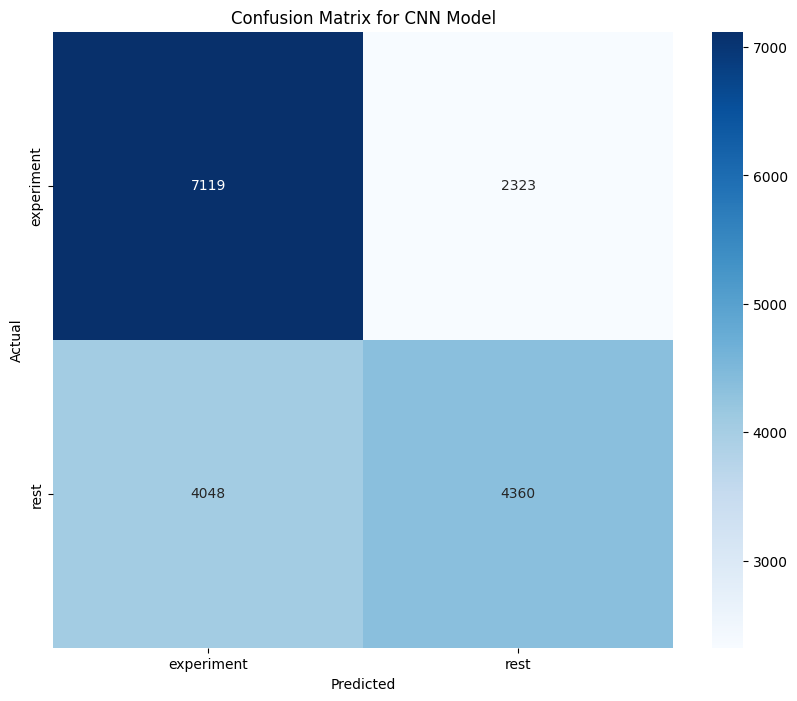

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


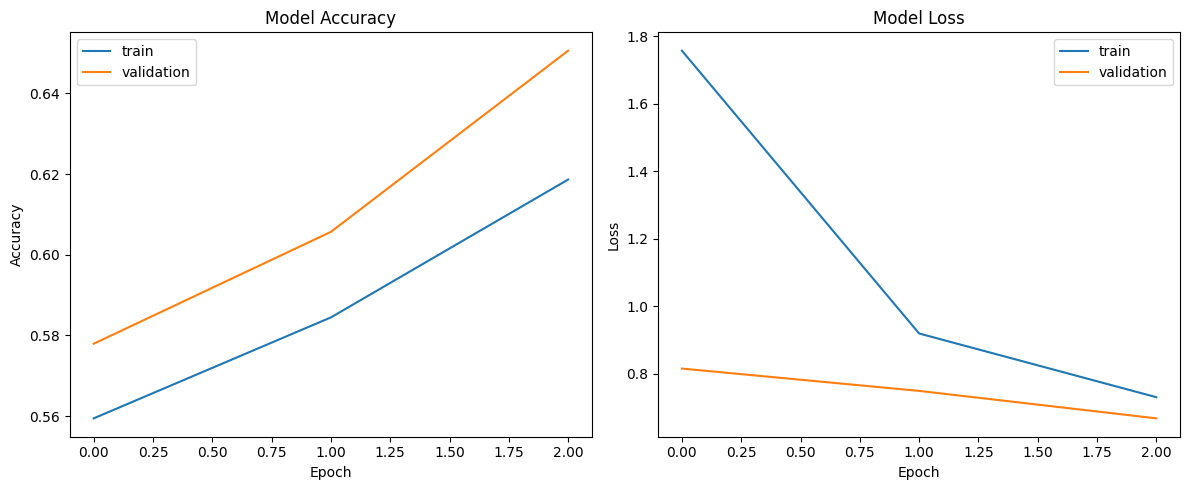

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(20,4), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose=0)

In [ ]:
# Evaluate model
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f" Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
 Results:
Accuracy: 0.6592

Classification Report:
              precision    recall  f1-score   support

  experiment       0.67      0.71      0.69      9442
        rest       0.65      0.61      0.63      8408

   micro avg       0.66      0.66      0.66     17850
   macro avg       0.66      0.66      0.66     17850
weighted avg       0.66      0.66      0.66     17850
 samples avg       0.66      0.66      0.66     17850


Confusion Matrix:


ValueError: multilabel-indicator is not supported

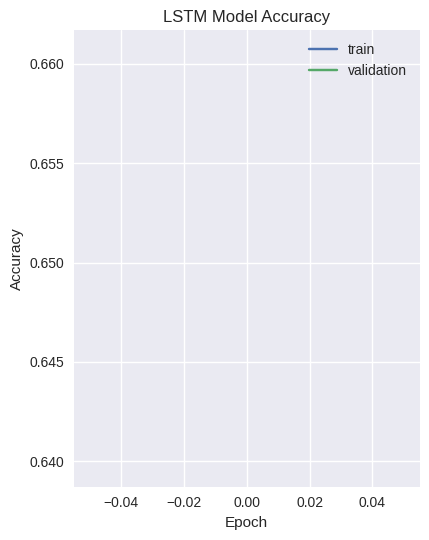

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='validation')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

5579/5579 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
5579/5579 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5579/5579 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
5579/5579 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5579/5579 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


NameError: name 'lstm_importance' is not defined

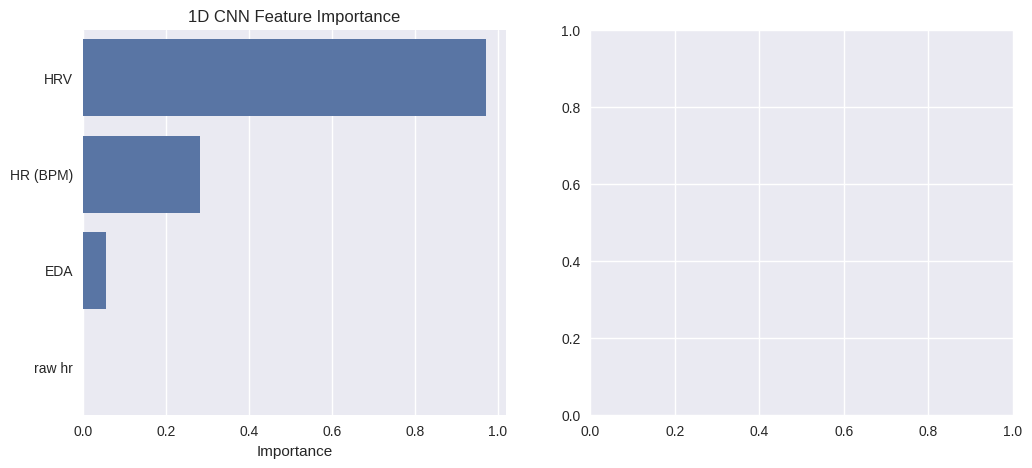

In [ ]:

# Feature importance analysis for deep learning models
def analyze_feature_importance(model, X, feature_names):
    original_pred = model.predict(X)
    feature_importance = []

    for i, feature in enumerate(feature_names):
        X_modified = X.copy()
        X_modified[:, i] = 0  # Set the feature to 0
        new_pred = model.predict(X_modified)
        importance = np.mean(np.abs(original_pred - new_pred))
        feature_importance.append((feature, importance))

    feature_importance.sort(key=lambda x: x[1], reverse=True)
    return feature_importance

cnn_importance = analyze_feature_importance(cnn_model, X_test_reshaped, X.columns)
lstm_importance = analyze_feature_importance(lstm_model, X_test_reshaped, X.columns)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=[f[1] for f in cnn_importance], y=[f[0] for f in cnn_importance])
plt.title('1D CNN Feature Importance')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
sns.barplot(x=[f[1] for f in lstm_importance], y=[f[0] for f in lstm_importance])
plt.title('LSTM Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

Example with simulated CPET dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)


Synthetic dataset with features commonly extracted from CPET:

VO2_Peak: Peak oxygen uptake.

AT: Anaerobic threshold.

VE_VCO2_Slope: Ventilatory efficiency.

HRR: Heart rate reserve.

Oxygen_Pulse: Oxygen pulse.

Morbidity: Target variable (0 = No morbidity, 1 = Morbidity).

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 500

# Simulate features
data = {
    'VO2_Peak': np.random.normal(20, 5, n_samples),      # ml/kg/min
    'AT': np.random.normal(14, 3, n_samples),            # ml/kg/min
    'VE_VCO2_Slope': np.random.normal(30, 5, n_samples),
    'HRR': np.random.normal(50, 10, n_samples),          # beats per minute
    'Oxygen_Pulse': np.random.normal(10, 2, n_samples),  # ml/beat
}

# Create DataFrame
df = pd.DataFrame(data)

# Simulate target variable
df['Morbidity'] = (
    (df['VO2_Peak'] < 18)
    | (df['AT'] < 12)
    | (df['VE_VCO2_Slope'] > 35)
).astype(int)

# Display first few rows
df.head()


,VO2_Peak,AT,VE_VCO2_Slope,HRR,Oxygen_Pulse,Morbidity
0,22.483571,16.778533,36.996777,57.783611,8.649643,1
1,19.308678,19.728250,34.623168,44.488143,9.710963,0
2,23.238443,9.804297,30.298152,41.818011,8.415160,1
3,27.615149,15.688908,26.765316,49.966255,9.384077,0
4,18.829233,12.048072,33.491117,48.298154,6.212771,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['VO2_Peak'].plot(kind='hist', bins=20, title='VO2_Peak')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['AT'].plot(kind='hist', bins=20, title='AT')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['VE_VCO2_Slope'].plot(kind='hist', bins=20, title='VE_VCO2_Slope')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='VO2_Peak', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='VO2_Peak', y='AT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='AT', y='VE_VCO2_Slope', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='VE_VCO2_Slope', y='HRR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['VO2_Peak']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('VO2_Peak')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['AT']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('AT')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['VE_VCO2_Slope']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('VE_VCO2_Slope')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['HRR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('HRR')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['VO2_Peak'].plot(kind='line', figsize=(8, 4), title='VO2_Peak')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['AT'].plot(kind='line', figsize=(8, 4), title='AT')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['VE_VCO2_Slope'].plot(kind='line', figsize=(8, 4), title='VE_VCO2_Slope')
plt.gca().spines[['top', 'right']].set_visible(False)

Preprocess the Data:

*   Separate features and target variable.
*   Handle missing values (if any).
*   Standardize the features.









In [ ]:
# Separate features and target
X = df.drop('Morbidity', axis=1)
y = df['Morbidity']

# Check for missing values
print("Missing values in each column:\n", X.isnull().sum())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Missing values in each column:
 VO2_Peak         0
AT               0
VE_VCO2_Slope    0
HRR              0
Oxygen_Pulse     0
dtype: int64


Applying PCA:

In [ ]:
# Initialize PCA - retain components that explain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Number of components selected:
print("Number of principal components:", pca.n_components_)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


Number of principal components: 5
Explained variance ratio: [0.23412906 0.21648436 0.189645   0.18557611 0.17416548]


Machine learning:

Splitting data and training a multivariate logistic regression model

Accuracy: 0.77

Confusion Matrix:
 [[24 16]
 [ 7 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.60      0.68        40
           1       0.77      0.88      0.82        60

    accuracy                           0.77       100
   macro avg       0.77      0.74      0.75       100
weighted avg       0.77      0.77      0.76       100



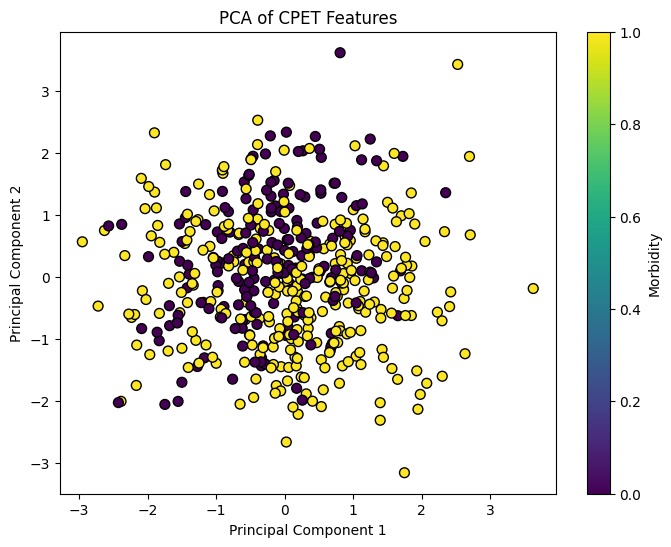

In [ ]:
# Split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# If PCA has 2 components
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50
    )
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of CPET Features')
    plt.colorbar(label='Morbidity')
    plt.show()



If necessary, we cna find outlers in the data (points that differs from the average and that could indicate anomalies or errors in the data)

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest

# Step 1: Create a synthetic dataset
np.random.seed(42)
X = np.random.rand(200, 10)  # 200 samples, 10 features

# Step 2: Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Assuming 10% outliers
outliers = iso_forest.fit_predict(X)  # -1 for outliers, 1 for inliers

# Step 3: Count and display the number of outliers
num_outliers = np.sum(outliers == -1)
print(f"Number of outliers detected: {num_outliers}")


Number of outliers detected: 20


We can then analyse the outlers separately before deciding what do to with them.

In [ ]:
X_outliers = X[outliers == -1]  # Extract outliers for further analysis
print(X_outliers)

[[0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
  0.30461377 0.09767211 0.68423303 0.44015249]
 [0.96958463 0.77513282 0.93949894 0.89482735 0.59789998 0.92187424
  0.0884925  0.19598286 0.04522729 0.32533033]
 [0.64203165 0.08413996 0.16162871 0.89855419 0.60642906 0.00919705
  0.10147154 0.66350177 0.00506158 0.16080805]
 [0.94045858 0.95392858 0.91486439 0.3701587  0.01545662 0.92831856
  0.42818415 0.96665482 0.96361998 0.85300946]
 [0.100778   0.01822183 0.09444296 0.68300677 0.07118865 0.31897563
  0.84487531 0.02327194 0.81446848 0.28185477]
 [0.08483771 0.98663958 0.3742708  0.37064215 0.81279957 0.94724858
  0.98600106 0.75337819 0.37625959 0.08350072]
 [0.01215447 0.96987883 0.04315991 0.89114311 0.52770111 0.9929648
  0.07379656 0.55385428 0.96930254 0.52309784]
 [0.6134152  0.41824304 0.93272848 0.86606389 0.04521867 0.02636697
  0.37646337 0.81055333 0.98727613 0.15041689]
 [0.81290101 0.99971767 0.99663684 0.55543171 0.76898742 0.94476573
  0.84964739 

We can then apply different techniques to remove the outlers: we can filter them out or alliviate their impact on the data by applying a log or no linear transformation

In [ ]:
# Apply log transformation to reduce the impact of extreme values
X_transformed = np.log1p(X)

When performing exploratory analysis of the data, different methods can be used, such as t-SNE (t-Distributed Stochastic Neighbor Embedding).

t-SNE is a dimensionality reduction technique primarily used for visualizing high-dimensional data. It is highly effective in preserving local relationships between data points.It is useful when visualising patterns (e.g., clusters of patients based on physiological responses). t-SNE can help provide insights into how patients with different CPET characteristics group together. however, it is not good for predictive modeling.

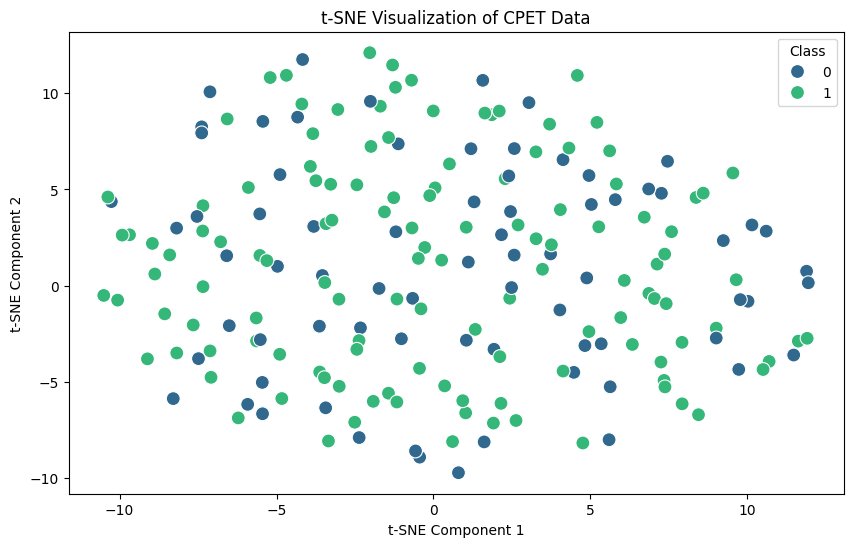

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

y = y[:X_tsne.shape[0]]

# Plot the result using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", s=100)

plt.title("t-SNE Visualization of CPET Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

We could also use LDA: if you have labeled outcomes (e.g., high vs. low morbidity risk), LDA can be helpful in extracting the features that best distinguish these classes.

ICA: can be useful for separating underlying signals in CPET data, such as respiratory and cardiac components, that may overlap or be confounded in the raw measurements.

Wavelet Transform: Since CPET data is often collected over time (e.g., heart rate, VO2 during exercise), wavelet transforms can be used to analyze different frequency components of these signals.


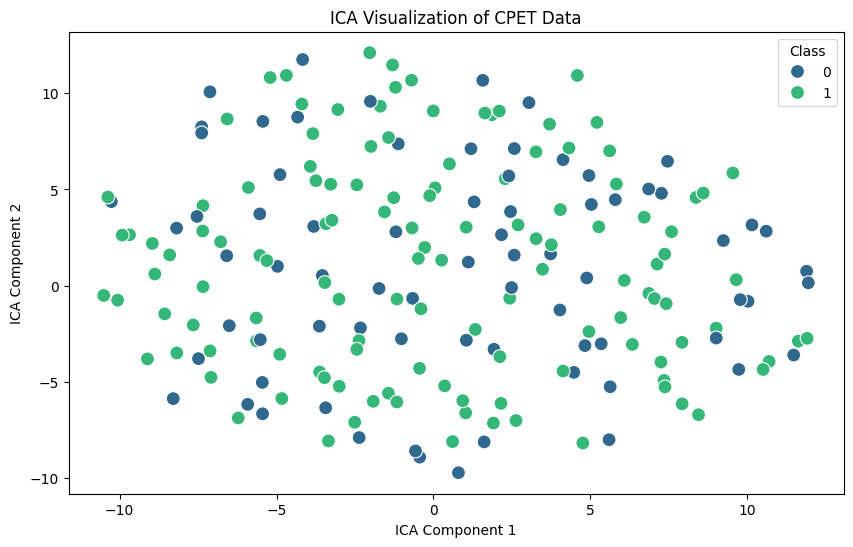

In [ ]:
#for ICA:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X)

#for Wavelet Transform:
#import pywt (!pip install pywt # Install the 'pywt' module before using it)
#coeffs = pywt.wavedec(X[:, 0], 'db1')  # Discrete Wavelet Transform on the first CPET variable

y = y[:X_tsne.shape[0]]

# Plot the result using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", s=100)

plt.title("ICA Visualization of CPET Data")
plt.xlabel("ICA Component 1")
plt.ylabel("ICA Component 2")
plt.legend(title="Class")
plt.show()